##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./demultiplex_QC/OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./demultiplex_QC/Merge_mappers.ipynb) 

In [4]:
%%R 
sampledata = read.csv("data/allsample_metadata_nomock_amendment2.csv")
sampledata$X = NULL
write.table(sampledata, "data/allsample_metadata_nomock_amendment2.txt", sep="\t")

In [5]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("data/allsample_metadata_nomock_amendment2.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 1), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3053 taxa and 70 samples ]
sample_data() Sample Data:       [ 70 samples by 14 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3053 tips and 3052 internal nodes ]


In [6]:
%%R
print(colnames(physeq.md))

 [1] "Sample"      "FractionNum" "Bulk"        "Control"     "CC"         
 [6] "X100"        "X700"        "H2O"         "Day"         "Density"    
[11] "rep"         "Treatment"   "amendment"   "amendment.1"


###Calculate pairwise weighted unifrac distances between samples.

In [7]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distances with NMDS.

In [8]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.1366314 
Run 1 stress 0.1461412 
Run 2 stress 0.1369965 
... procrustes: rmse 0.01444774  max resid 0.1106228 
Run 3 stress 0.1369338 
... procrustes: rmse 0.01290137  max resid 0.1021365 
Run 4 stress 0.138825 
Run 5 stress 0.1462609 
Run 6 stress 0.1366325 
... procrustes: rmse 0.0002433801  max resid 0.001752025 
*** Solution reached


In [9]:
%%R
df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))
head(df)

                        NMDS1        NMDS2           Sample FractionNum Bulk
00C.000.14.09.NA -0.007991285 -0.030021439 00C.000.14.09.NA          NA    1
13C.100.14.08.NA  0.026990960 -0.045856955 13C.100.14.08.NA          NA    1
12C.700.28.04.NA  0.019590473  0.007565100 12C.700.28.04.NA          NA    1
13C.000.45.04.NA  0.001683421  0.016996523 13C.000.45.04.NA          NA    1
13C.700.28.06.NA -0.123277211  0.028424351 13C.700.28.06.NA          NA    1
12C.000.14.05.NA  0.025719469 -0.009929916 12C.000.14.05.NA          NA    1
                 Control CC X100 X700 H2O Day Density rep Treatment amendment
00C.000.14.09.NA       1  0    0    0   1  14      NA       control     Water
13C.100.14.08.NA       0  0    1    0   0  14      NA         label    13C100
12C.700.28.04.NA       1  0    0    1   0  28      NA       control    12C700
13C.000.45.04.NA       0  1    0    0   0  45      NA         label      13CC
13C.700.28.06.NA       0  0    0    1   0  28      NA         label    

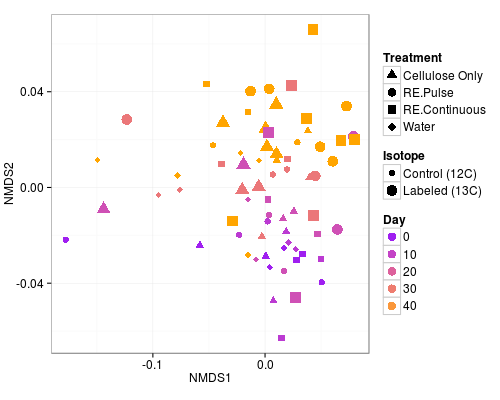

In [18]:
%%R -w 500 -h 400 

#colours = c("#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")
colours = c("#660066", "#CCCC00", "#666666", "#009999", "#CC0033", "#99CC00", "black")


df$amendment.1 = as.character(df$amendment.1)
#df$Day = as.character(df$Day)

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(shape = amendment.1, size = Treatment, color = Day)) 

p1 = p1 + scale_size_manual(values = c(3, 5), 
                           name = "Isotope",
                           breaks=c("control", "label"),
                           labels = c("Control (12C)", "Labeled (13C)"))

p1 = p1 + scale_shape_manual(values = c(15, 16, 17, 18, 19),
                             name = "Treatment",
                             breaks=c("CC", "C700", "C100", "Water", "T0"),
                             labels=c("Cellulose Only", "RE.Pulse", "RE.Continuous", "Water", "T0"))


#p1 = p1 + scale_color_gradient(low="#CF142B", high="#0065BD")
p1 = p1 + scale_color_gradient(low="purple", high="orange")

p1 = p1 + guides(alpha = FALSE)

p1 = p1 + theme_bw()

p1 = p1 + guides(color = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(shape = guide_legend(override.aes = list(size = 4)))

p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))


p1

In [11]:
%%R 
pdf("figs/bulk_ordination.pdf", width = 7, height = 5)
grid.arrange(p1, ncol = 1)
dev.off()

png 
  2 


In [12]:
FileLink("figs/bulk_ordination.pdf")

/home/ashley/priming_exp/figs/bulk_ordination.pdf

In [13]:
%%R 
png("figs/bulk_ordination.png", width = 7, height = 5, units = "in", res = 600)
grid.arrange(p1, ncol = 1)
dev.off()

png 
  2 


In [14]:
FileLink("figs/bulk_ordination.png")

/home/ashley/priming_exp/figs/bulk_ordination.png

In [26]:
%%R
library(vegan)

Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


In [30]:
%%R
#convert physeq object to a dataframe for adonis test
md = sample_data(physeq.PE.thresh)
#convert dataframe from physeq to a traditional R dataframe because it has funky 'class'
md = data.frame(md)

In [63]:
%%R
#to test if community composition in Bulk DNA sequencing is different between treatments
stat.bulk = adonis(wunif.dist ~ amendment*factor(Day), data = md, permutations = 1000)
stat.bulk


Call:
adonis(formula = wunif.dist ~ amendment * factor(Day), data = md,      permutations = 1000) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

                      Df SumsOfSqs   MeanSqs F.Model      R2   Pr(>F)    
amendment              6   0.09958 0.0165960  4.0859 0.23870 0.000999 ***
factor(Day)            4   0.04812 0.0120289  2.9615 0.11534 0.001998 ** 
amendment:factor(Day) 18   0.10293 0.0057182  1.4078 0.24674 0.043956 *  
Residuals             41   0.16653 0.0040618         0.39922             
Total                 69   0.41715                   1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [33]:
%%R
stat.bulk.day = adonis(wunif.dist ~ factor(Day), data = md)
stat.bulk.day


Call:
adonis(formula = wunif.dist ~ factor(Day), data = md) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

            Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)   
factor(Day)  4   0.05766 0.0144160  2.6066 0.13823  0.002 **
Residuals   65   0.35949 0.0055306         0.86177          
Total       69   0.41715                   1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
